In [1]:
import mne
from mne.preprocessing import ICA
from pathlib import Path

# 1. Configuration
bids_root = Path(r"C:\Users\noahm\projects\loc_analysis\data\derivatives")
sub_number = "02"
task = "loc"

# Define Paths
deriv_root = bids_root / f"sub-{sub_number}" / "eeg"
fname_in = deriv_root / f"sub-{sub_number}_task-{task}_downsamp-2_eeg.fif"
fname_out = deriv_root / f"sub-{sub_number}_task-{task}_downsamp-2_desc-filteredICAdReref_eeg.fif"


print(f"Processing Subject: {sub_number}")
print(f"Input file: {fname_in}")
print(f"Output file: {fname_out}")

Processing Subject: 02
Input file: C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-02\eeg\sub-02_task-loc_downsamp-2_eeg.fif
Output file: C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-02\eeg\sub-02_task-loc_downsamp-2_desc-filteredICAdReref_eeg.fif


In [ ]:
# 2. Load Data
# MNE will automatically load the 'bads' you marked in the previous script.
raw = mne.io.read_raw_fif(fname_in, preload=True)

# Quick check of info to ensure bads are present
print("Bad channels marked:", raw.info['bads'])

Opening raw data file C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-02\eeg\sub-02_task-loc_downsamp-2_eeg.fif...
    Range : 0 ... 1294719 =      0.000 ...  2589.438 secs
Ready.
Reading 0 ... 1294719  =      0.000 ...  2589.438 secs...
Bad channels marked: ['Fp2', 'FT9', 'AF8', 'Oz', 'O2']
Using qt as 2D backend.


<mne_qt_browser._pg_figure.MNEQtBrowser(0x15b67f02e80) at 0x0000015B644EBB00>

Channels marked as bad:
['Fp2', 'FT9', 'AF8', 'Oz', 'O2', np.str_('CP6')]


### Filtering

In [3]:
filt_raw = raw.load_data().filter(l_freq=0.5, h_freq=120.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3301 samples (6.602 s)



Used Annotations descriptions: [np.str_('dist_end'), np.str_('dist_start'), np.str_('enc_act1'), np.str_('enc_act2'), np.str_('enc_act3'), np.str_('enc_cue'), np.str_('enc_end'), np.str_('enc_fixation'), np.str_('enc_q_color'), np.str_('enc_q_schema'), np.str_('enc_resp_left'), np.str_('enc_resp_right'), np.str_('enc_start'), np.str_('prac_end'), np.str_('prac_start'), np.str_('psychopy_enc_starts'), np.str_('psychopy_ret_starts'), np.str_('ret_cue_new'), np.str_('ret_cue_old_sc_pc'), np.str_('ret_cue_old_sc_pi'), np.str_('ret_cue_old_si_pc'), np.str_('ret_cue_old_si_pi'), np.str_('ret_end'), np.str_('ret_fixation'), np.str_('ret_q1_new'), np.str_('ret_q1_old_sc_pc'), np.str_('ret_q1_old_sc_pi'), np.str_('ret_q1_old_si_pc'), np.str_('ret_q1_old_si_pi'), np.str_('ret_q1_resp_left'), np.str_('ret_q1_resp_right'), np.str_('ret_q2_old_sc_pc'), np.str_('ret_q2_old_sc_pi'), np.str_('ret_q2_old_si_pc'), np.str_('ret_q2_old_si_pi'), np.str_('ret_q2_resp_left'), np.str_('ret_q2_resp_right'), np

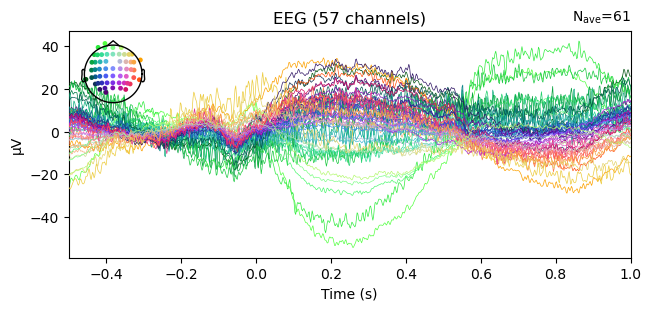

In [4]:
# Have a look at the Evoked potential during experimental event (here Encoding) to check if the filtering has worked
events, event_dict = mne.events_from_annotations(filt_raw)
epochs = mne.Epochs(
    filt_raw,
    events,
    event_id=event_dict,
    tmin=-0.5,
    tmax=1,
    reject_by_annotation=True, # default parameter
)['ret_fixation'].average().plot()

Notch filter out 50Hz

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 1033851 of 3109760 (33.25%) samples to NaN, retaining 2075909 (66.75%) samples.
Effective window size : 2.048 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.


/Users/ivan_/miniconda3/envs/mne/lib/python3.9/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 400, using nperseg = 400
  return _func(*args, **kwargs)


Plotting power spectral density (dB=True).


/Users/ivan_/miniconda3/envs/mne/lib/python3.9/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1645, using nperseg = 1645
  return _func(*args, **kwargs)
/Users/ivan_/miniconda3/envs/mne/lib/python3.9/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 521, using nperseg = 521
  return _func(*args, **kwargs)
/Users/ivan_/miniconda3/envs/mne/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


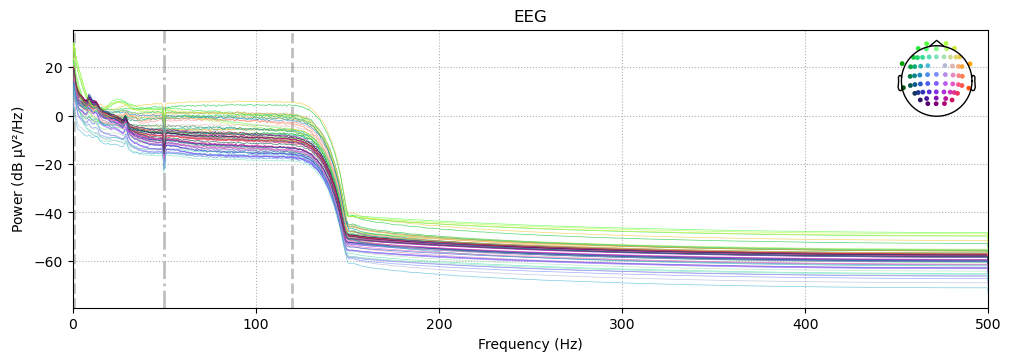

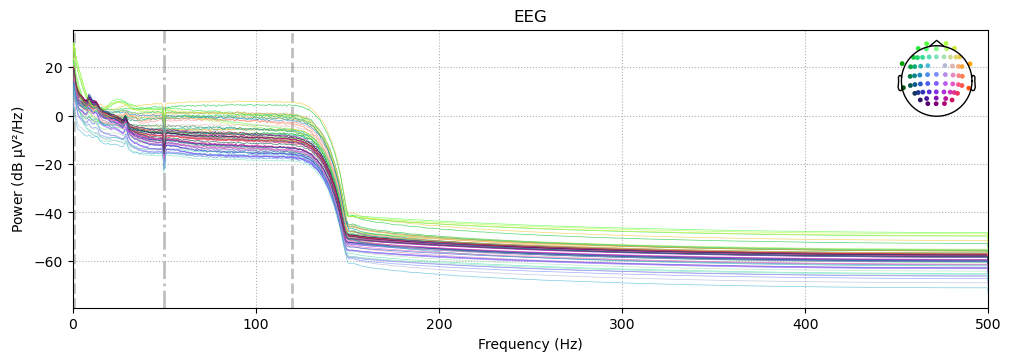

In [32]:
filt_raw.notch_filter(freqs=50, verbose=False)
filt_raw.plot_psd()

In [33]:
filt_raw.plot()

Using pyopengl with version 3.1.9


Channels marked as bad:
none


### ICA for ocular movements

In [34]:
ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Omitting 1033851 of 3109760 (33.25%) samples, retaining 2075909 (66.75%) samples.
Selecting by number: 15 components
Fitting ICA took 30.9s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,33 iterations on raw data (2075909 samples)
ICA components,15
Available PCA components,63
Channel types,eeg
ICA components marked for exclusion,—


In [35]:
ica.plot_sources(filt_raw, show_scrollbars=False)

Creating RawArray with float64 data, n_channels=15, n_times=3109760
    Range : 0 ... 3109759 =      0.000 ...  3109.759 secs
Ready.
Using pyopengl with version 3.1.9


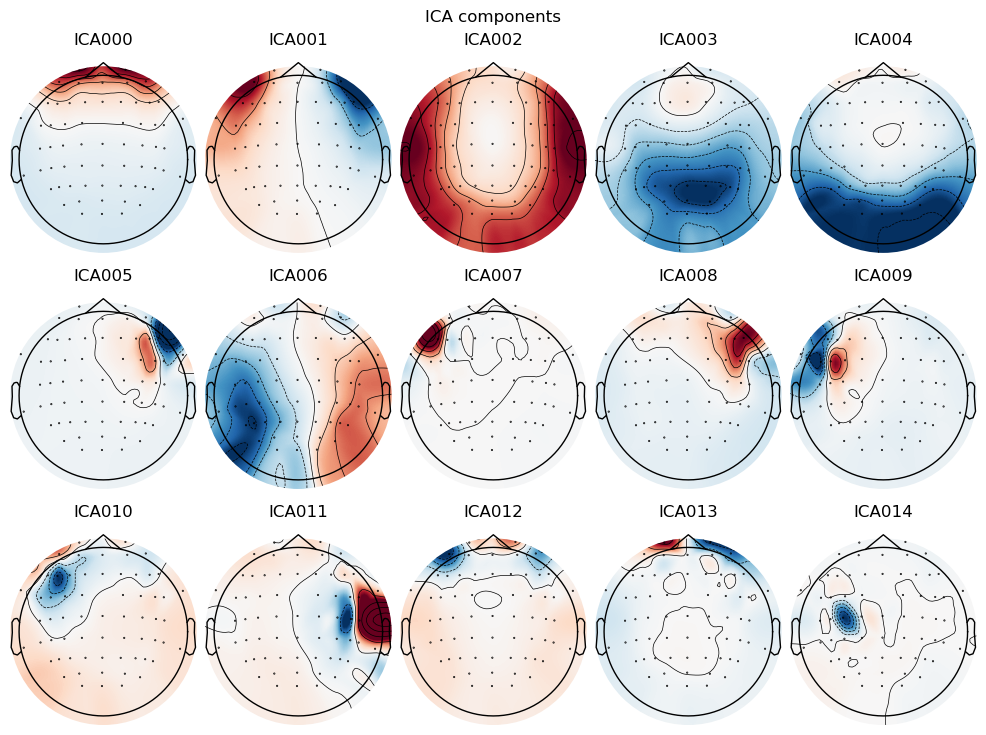

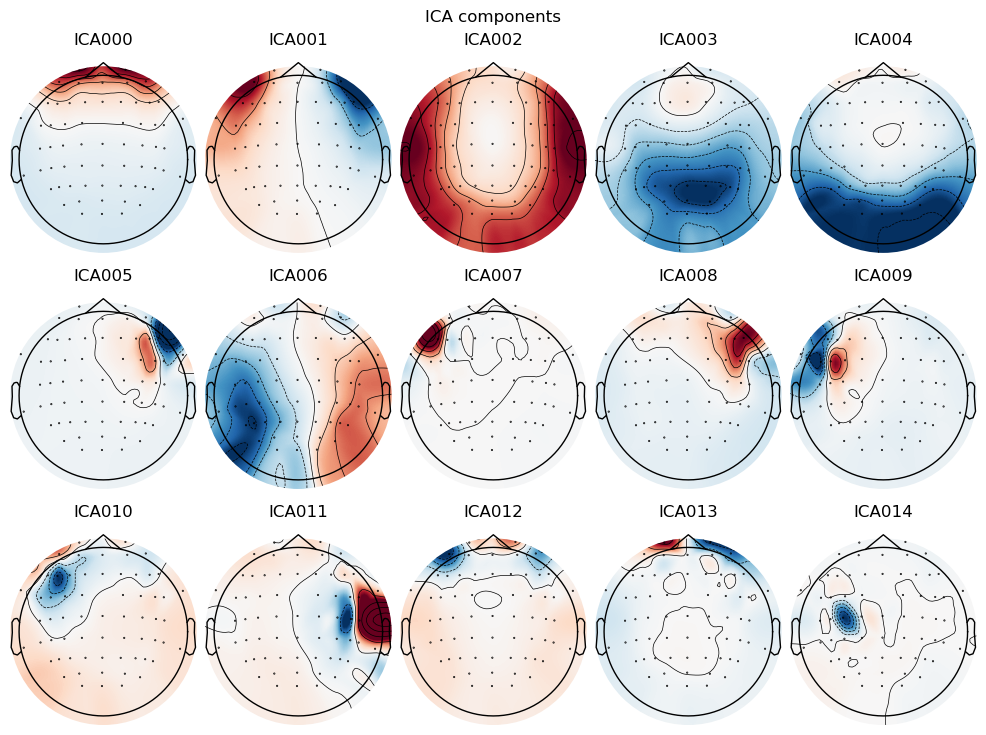

In [36]:
ica.plot_components()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components


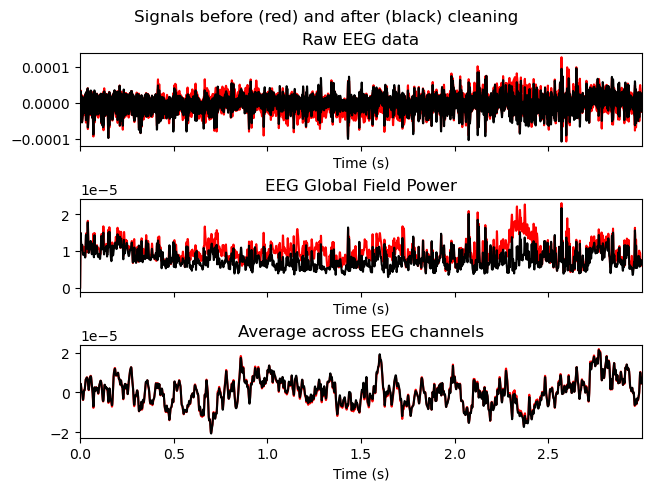

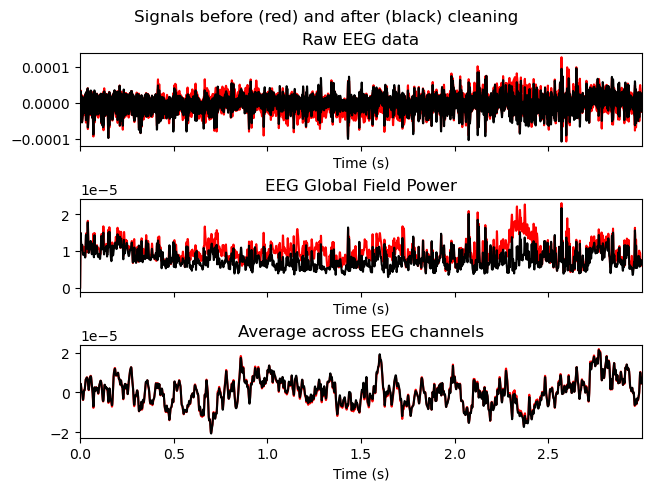

In [37]:
# blinks
ica.plot_overlay(filt_raw, exclude=[0, 1], picks="eeg")

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1003 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1003 matching events found
No baseline correction applied
0 projection items activated


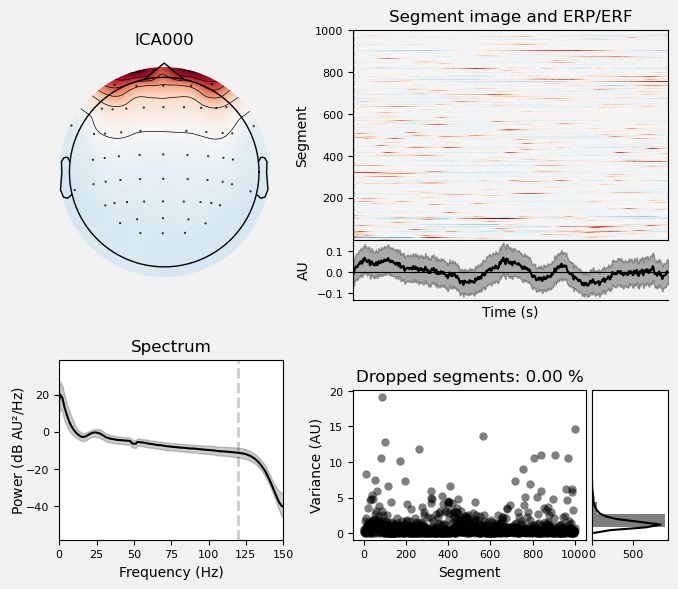

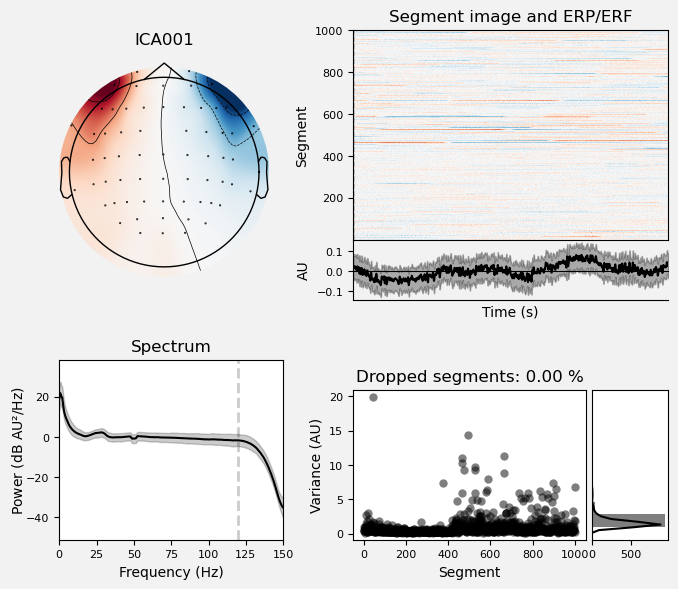

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [38]:
ica.plot_properties(filt_raw, picks=[0, 1])

In [39]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = filt_raw.copy()
ica.exclude = [0, 1]
ica.apply(reconst_raw)
reconst_raw.plot()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components
Using pyopengl with version 3.1.9


Channels marked as bad:
none


In [ ]:
# Rereference the raw data (Ivan did this with the epoch object)
raw_avg_ref = reconst_raw.copy().set_eeg_reference(ref_channels="average")
raw_avg_ref.plot()

In [ ]:
raw_avg_ref.save(fname_out, overwrite=True)
print(f"Saved preprocessed EEG to: {fname_out}")